In [1]:
import numpy as np
import os 
import pickle

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

from architectures.condDCGAN import *
from architectures.utils.toolbox import *

In [71]:
task='TEST'

PATH='HCAL_condDCGAN_3dim_test13'

In [72]:
if task == 'TEST' and os.path.exists(PATH+'/hyper_parameters.pkl'):
    with open(PATH+'/hyper_parameters.pkl', 'rb') as f:  
        hyper_dict = pickle.load(f)
        for key, item in hyper_dict.items():
            print(key+':'+str(item))
     
    reco_path = hyper_dict['reco_path']
    true_path = hyper_dict['true_path']
    n_batches = hyper_dict['n_batches']
    test_size = hyper_dict['test_size']
    LEARNING_RATE = hyper_dict['LEARNING_RATE']
    BETA1 = hyper_dict['BETA1']
    BATCH_SIZE = hyper_dict['BATCH_SIZE']
    EPOCHS = hyper_dict['EPOCHS']
    SAVE_SAMPLE_PERIOD = hyper_dict['SAVE_SAMPLE_PERIOD']
    SEED = hyper_dict['SEED']
    d_sizes = hyper_dict['d_sizes']
    g_sizes = hyper_dict['g_sizes']
    preprocess = hyper_dict['preprocess']
    cost_type = hyper_dict['cost_type']
    validating_size=hyper_dict['validating_size']
    discr_steps=hyper_dict['discr_steps']
    gen_steps=hyper_dict['gen_steps']

if task == 'TEST' and not os.path.exists(PATH+'/hyper_parameters.pkl'):
    
    print('Missing hyperparameter dictionary in save folder')
    
    
    

LEARNING_RATE:0.00015
BETA1:0.5
BATCH_SIZE:32
EPOCHS:20
SAVE_SAMPLE_PERIOD:600
SEED:1
d_sizes:{'conv_layers': [(4.0, 4, 2, False, 0.8, <function lrelu at 0x7f6e45bf10d0>, <tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f6e3d513a20>), (64, 4, 2, 'bn', 1, <function lrelu at 0x7f6e45bf10d0>, <tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f6e3d08f198>), (128, 4, 2, 'bn', 1, <function lrelu at 0x7f6e45bf10d0>, <tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f6e3d08f208>), (128, 4, 2, 'bn', 1, <function lrelu at 0x7f6e45bf10d0>, <tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f6e3d08f278>)], 'dense_layers': [(128, 'bn', 0.8, <function lrelu at 0x7f6e45bf10d0>, <tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f6e3d08f320>), (16, False, 0.8, <function lrelu at 0x7f6e45bf10d0>, <tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f6e3d08f3c8>)], 'readout_layer_w_init': <tensorflow.python.ops.init_ops.TruncatedNormal object

In [73]:
dim=10
test_size=10000
if preprocess=='normalise':
    train_true, test_true, min_true, max_true, train_reco, test_reco, min_reco, max_reco = load_data_conditional(true_path, reco_path, n_batches=2, preprocess='normalise', test_size=test_size)
else:
    train_true, test_true, train_reco, test_reco = load_data_conditional(true_path, reco_path, n_batches, dim, preprocess, test_size)
#train_true, train_reco = delete_undetected_events(train_true,train_reco)
#test_true, test_reco = delete_undetected_events(train_true,train_reco)

In [74]:
#test_true[:,2,:].max()
#pos_max=np.where(test_true[:,2,:]==test_true[:,2,:].max())[0]
#test_true_deleted=np.delete(test_true, pos_max[0], axis=0)

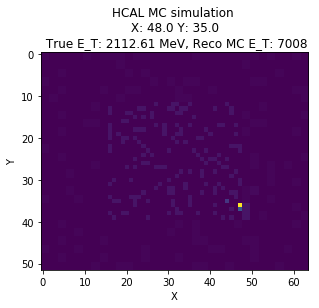

In [75]:
if preprocess != False:
    draw_one_sample_conditional(train_true, train_reco, preprocess,
                    min_true=min_true, max_true=max_true, 
                    min_reco=min_reco, max_reco=max_reco,
                    save=False, PATH=PATH
                   )
else:
    draw_one_sample_conditional(train_true,train_reco)

In [76]:
h=test_reco[0].shape[0]
w=test_reco[0].shape[1]

In [77]:
def HCAL():
    
    tf.reset_default_graph()
    _, n_H, n_W, n_C = train_reco.shape
    gan = condDCGAN(dim_y=3, n_H=n_H, n_W=n_W, n_C=n_C,
                min_true=min_true, max_true=max_true,
                min_reco=min_reco, max_reco=max_reco,
                d_sizes=d_sizes, g_sizes=g_sizes,
                lr=LEARNING_RATE, beta1=BETA1, preprocess=preprocess,
                cost_type = cost_type,
                discr_steps=discr_steps, gen_steps=gen_steps,
                batch_size=BATCH_SIZE, epochs=EPOCHS,
                save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed= SEED)
    
    vars_to_train= tf.trainable_variables()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
        
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(init_op)

        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            gan.set_session(sess) 
            
        test_reco_NN = np.ndarray(shape=(len(test_reco),52,64,1))        
        for i in range(len(test_reco)):
            
            test_reco_NN[i]=gan.get_sample(test_true[i].reshape(1,3))
            
        done = False
        while not done:
            
            
            
            if preprocess!=False:
                draw_nn_sample_conditional(test_true, test_reco, 1, preprocess,
                                          min_true=min_true, max_true=max_true,
                                          min_reco=min_reco, max_reco=max_reco,
                                          f=gan.get_samples, save=False, is_training=False, PATH=PATH)
            else:
                draw_nn_sample_conditional(test_true, test_reco, 1, preprocess,
                                          f=gan.get_samples, save=False, is_training=False, PATH=PATH)
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True
            
        done = True
        while not done:
            
            if preprocess!=False:
                draw_nn_sample_conditional(test_true, test_reco, 1, preprocess,
                                          min_true=min_true, max_true=max_true,
                                          min_reco=min_reco, max_reco=max_reco,
                                          f=gan.get_samples, save=False, is_training=False, PATH=PATH)
            else:
                draw_nn_sample_conditional(test_true, test_reco, 1, preprocess,
                                          f=gan.get_samples, save=False, is_training=False, PATH=PATH)
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

        
        return test_reco_NN

Convolutional Network architecture detected for discriminator A
Convolutional architecture detected for generator A
Discriminator_A
Convolution
Input for convolution shape  (?, 52, 64, 4)
minibatch features shape (?, 5)
Logits shape (?, 1)
Generator_A
Deconvolution
Input for deconvolution shape (?, 131)
Deconvoluted output shape (?, 52, 64, 1)
Discriminator_A
Convolution
Input for convolution shape  (?, 52, 64, 4)
minibatch features shape (?, 5)
Logits shape (?, 1)
Generator_A
Deconvolution
Input for deconvolution shape (?, 131)
Deconvoluted output shape (?, 52, 64, 1)

 Evaluate model on test set...
INFO:tensorflow:Restoring parameters from HCAL_condDCGAN_3dim_test13/HCAL_condDCGAN_3dim_test13.ckpt
Model restored.


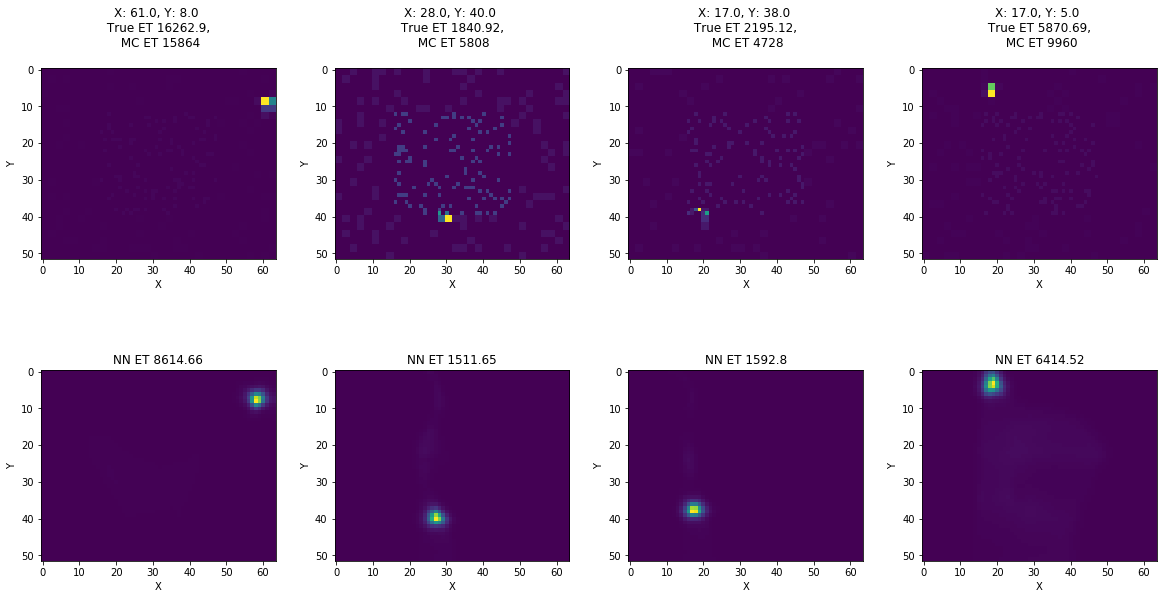

Generate another?n


In [78]:
if __name__=='__main__':

    if task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            test_reco_NN =HCAL()

In [79]:
if preprocess=='normalise':
    
    test_reco_MC = denormalise(test_reco, min_reco, max_reco)
    reco_MC_hist = test_reco_MC.reshape(test_reco.shape[0], test_reco.shape[1]*test_reco.shape[2])
    reco_MC_hist = np.sum(reco_MC_hist,axis=1)
    max_E=np.max(reco_MC_hist)
    
    test_reco_NN_denormalised = denormalise(test_reco_NN, min_reco, max_reco)
    reco_NN_hist = test_reco_NN_denormalised.reshape(test_reco_NN.shape[0], test_reco_NN.shape[1]*test_reco_NN.shape[2])
    reco_NN_hist = np.sum(reco_NN_hist,axis=1)
    max_NN = np.max(reco_NN_hist)
    
    test_true= denormalise(test_true, min_true, max_true, norm_space=True)
    true_hist = test_true[:,2,:]
    #true_hist = np.sum(true_hist,axis=1)
    max_true_E=np.max(true_hist)
else:
    reco_MC_hist = test_reco.reshape(test_reco.shape[0], test_reco.shape[1]*test_reco.shape[2])
    reco_MC_hist = np.sum(reco_MC_hist,axis=1)
    max_E=np.max(reco_MC_hist)
    
    reco_NN_hist = test_reco_NN.reshape(test_reco_NN.shape[0], test_reco_NN.shape[1]*test_reco_NN.shape[2])
    reco_NN_hist = np.sum(reco_NN_hist,axis=1)
    max_NN = np.max(reco_NN_hist)
    
    true_hist = test_true.reshape(test_true.shape[0], test_true.shape[1]*test_true.shape[2])
    true_hist = np.sum(true_hist,axis=1)
    max_true_E=np.max(true_hist)

In [80]:
max_NN=test_reco_NN_denormalised.max()
max_MC=test_reco_MC.max()
print('Max NN {0}, Max_MC {1}'.format(max_NN, max_MC))
test_reco_NN_rescaled=(test_reco_NN_denormalised/test_reco_NN_denormalised.max())*max_MC

Max NN 821.726548075676, Max_MC 6120.0


In [81]:
test_reco_inner = get_inner_HCAL(test_reco_MC)
test_reco_outer = get_outer_HCAL(test_reco_MC)

In [82]:
test_reco_inner_NN = get_inner_HCAL(test_reco_NN_rescaled)
test_reco_outer_NN = get_outer_HCAL(test_reco_NN_rescaled)

In [83]:
indices_MC, triggered_true_MC, triggered_reco_inner_MC, triggered_reco_outer_MC = get_triggered_events(test_true, test_reco_inner, test_reco_outer)


In [84]:
indices_NN, triggered_true_NN, triggered_reco_inner_NN, triggered_reco_outer_NN = get_triggered_events(test_true, test_reco_inner_NN, test_reco_outer_NN)

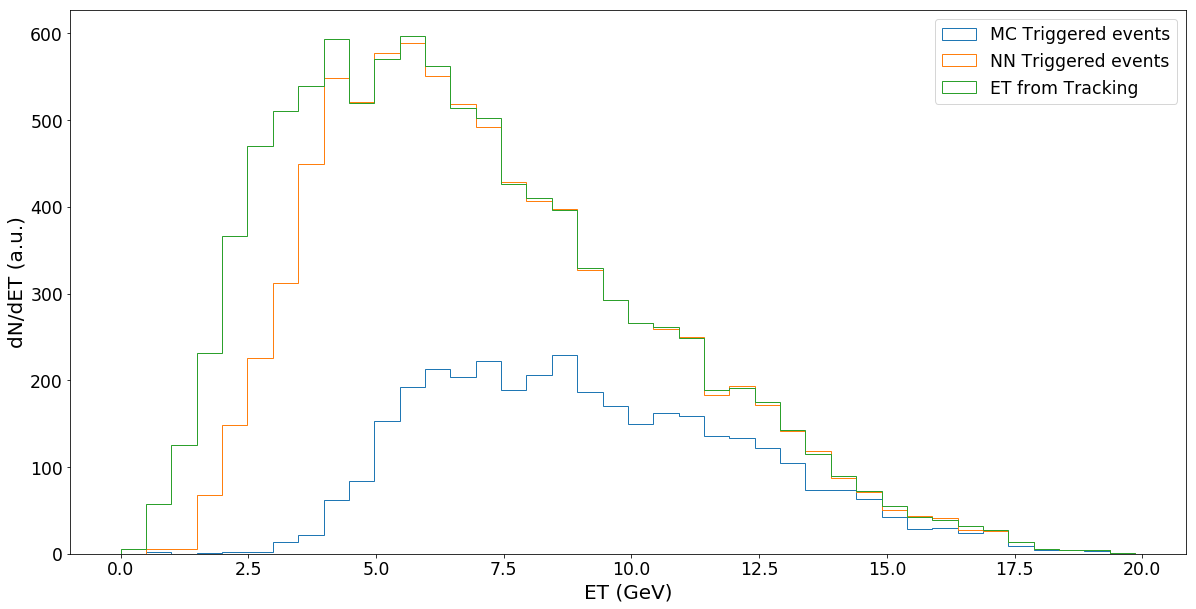

In [85]:
a_MC=plt.hist(triggered_true_MC/1000,bins=40,histtype='step', range=(0, max_true_E/1000), label='MC Triggered events')
a_NN=plt.hist(triggered_true_NN/1000-0.08,bins=40,histtype='step', range=(0, max_true_E/1000), label='NN Triggered events')
b=plt.hist(true_hist/1000,bins=40,histtype='step', range=(0, max_true_E/1000), label='ET from Tracking')
plt.tick_params(labelsize='xx-large')
plt.xlabel('ET (GeV)', fontsize=20)
plt.ylabel('dN/dET (a.u.)', fontsize=20)
plt.legend(fontsize='xx-large')
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.savefig(PATH+'/eff_1.png',dpi=100)

In [86]:
a_MC


(array([  0.,   2.,   0.,   1.,   2.,   2.,  14.,  22.,  62.,  84., 153.,
        192., 213., 204., 222., 189., 206., 229., 187., 171., 150., 162.,
        159., 136., 134., 122., 105.,  73.,  73.,  63.,  42.,  29.,  30.,
         24.,  26.,   9.,   4.,   4.,   3.,   0.]),
 array([ 0.        ,  0.49653198,  0.99306396,  1.48959595,  1.98612793,
         2.48265991,  2.97919189,  3.47572388,  3.97225586,  4.46878784,
         4.96531982,  5.46185181,  5.95838379,  6.45491577,  6.95144775,
         7.44797974,  7.94451172,  8.4410437 ,  8.93757568,  9.43410767,
         9.93063965, 10.42717163, 10.92370361, 11.4202356 , 11.91676758,
        12.41329956, 12.90983154, 13.40636353, 13.90289551, 14.39942749,
        14.89595947, 15.39249146, 15.88902344, 16.38555542, 16.8820874 ,
        17.37861938, 17.87515137, 18.37168335, 18.86821533, 19.36474731,
        19.8612793 ]),
 <a list of 1 Patch objects>)

In [62]:
a_NN
    

(array([  0.,  11.,  17.,  71., 172., 239., 285., 333., 354., 366., 449.,
        489., 514., 511., 491., 429., 407., 398., 327., 293., 266., 259.,
        250., 183., 194., 172., 142., 119.,  87.,  71.,  51.,  44.,  41.,
         28.,  26.,  14.,   6.,   4.,   4.,   1.]),
 array([ 0.        ,  0.49653198,  0.99306396,  1.48959595,  1.98612793,
         2.48265991,  2.97919189,  3.47572388,  3.97225586,  4.46878784,
         4.96531982,  5.46185181,  5.95838379,  6.45491577,  6.95144775,
         7.44797974,  7.94451172,  8.4410437 ,  8.93757568,  9.43410767,
         9.93063965, 10.42717163, 10.92370361, 11.4202356 , 11.91676758,
        12.41329956, 12.90983154, 13.40636353, 13.90289551, 14.39942749,
        14.89595947, 15.39249146, 15.88902344, 16.38555542, 16.8820874 ,
        17.37861938, 17.87515137, 18.37168335, 18.86821533, 19.36474731,
        19.8612793 ]),
 <a list of 1 Patch objects>)

In [63]:
b

(array([  5.,  58., 125., 231., 366., 470., 511., 540., 594., 520., 571.,
        597., 563., 514., 502., 426., 410., 397., 330., 293., 266., 262.,
        249., 189., 191., 175., 143., 115.,  90.,  72.,  55.,  43.,  39.,
         32.,  27.,  14.,   6.,   4.,   4.,   1.]),
 array([ 0.        ,  0.49653198,  0.99306396,  1.48959595,  1.98612793,
         2.48265991,  2.97919189,  3.47572388,  3.97225586,  4.46878784,
         4.96531982,  5.46185181,  5.95838379,  6.45491577,  6.95144775,
         7.44797974,  7.94451172,  8.4410437 ,  8.93757568,  9.43410767,
         9.93063965, 10.42717163, 10.92370361, 11.4202356 , 11.91676758,
        12.41329956, 12.90983154, 13.40636353, 13.90289551, 14.39942749,
        14.89595947, 15.39249146, 15.88902344, 16.38555542, 16.8820874 ,
        17.37861938, 17.87515137, 18.37168335, 18.86821533, 19.36474731,
        19.8612793 ]),
 <a list of 1 Patch objects>)

In [89]:
eff_MC = np.zeros_like(b[0])
eff_NN = np.zeros_like(b[0])
for i in range(len(b[0])):
    if b[0][i]!=0:
        eff_MC[i]=a_MC[0][i]/b[0][i]
        if a_NN[0][i]>b[0][i]:
            eff_NN[i]=1
        else:
            eff_NN[i]=a_NN[0][i]/b[0][i]

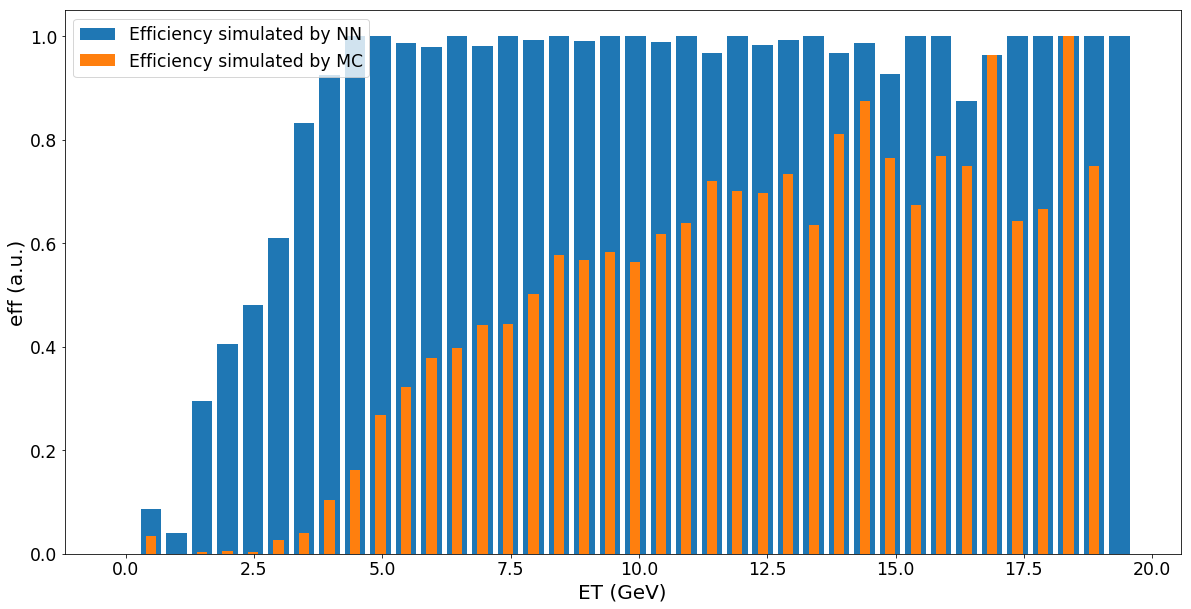

In [90]:
idx = np.arange(0,max_true_E/1000, step=(max_true_E/1000)/40)

plt.bar(idx,eff_NN, width=0.4, label='Efficiency simulated by NN')
plt.bar(idx,eff_MC, width=0.2, label='Efficiency simulated by MC')
plt.legend(fontsize='xx-large')
plt.tick_params(labelsize='xx-large')
plt.xlabel('ET (GeV)', fontsize=20)
plt.ylabel('eff (a.u.)', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.savefig(PATH+'/eff_2.png',dpi=100)